IMPORTS

In [2]:
# CORE PYTHON & DATA MANIPULATION LIBRARIES
import numpy as np                # Numerical computations, arrays, math operations
import pandas as pd               # Data handling, DataFrames, time-series structures
import os                         # OS-level utilities (path handling, directory checks, file management)
# VISUALIZATION LIBRARIES
import matplotlib.pyplot as plt   # Main plotting library
import seaborn as sns             # Statistical and enhanced visualization tools
# STEP 3) DECOMPOSING
from statsmodels.tsa.seasonal import seasonal_decompose         # Decompose time-series into trend, seasonal, and residual components
from statsmodels.tsa.stattools import acf                       # Compute autocorrelation values
# STEP 4) STATIONARITY ANALYSIS
from statsmodels.tsa.stattools import adfuller                  # Dickey-Fuller test for stationarity evaluation
# STEP 5) RESIDUALS DIAGNOSTICS
from statsmodels.stats.diagnostic import acorr_ljungbox         # Ljung-Box test for checking autocorrelation in residuals
# STEP 6) ACF/PACF DIAGNOSTICS + ORDER GRIDS
from statsmodels.tsa.stattools import pacf                      # Compute partial autocorrelation values
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf   # Plot ACF & PACF with confidence bands

HELPER FUNCTIONS

In [40]:
# ===============================
# Log printer
# ===============================
def log(
    message: str,
    icon: str = "INFO",
    level: int = 1,
    bold: bool = False
):
    # Icon dictionary (semantic → emoji)
    icons = {
        "INFO": "ℹ️",
        "FOUND": "🔍",
        "SUCCESS": "✅",
        "ERROR": "❌",
        "WARNING": "⚠️",
    }

    # If icon matches a key → use mapped emoji
    # Else → assume user passed a custom emoji/string
    final_icon = icons.get(icon.upper(), icon)
    # Bold wrapper (ANSI)
    if bold:
        message = f"\033[1m{message}\033[0m"
    # Prefix by level
    if level == 1:
        prefix = "•"
    elif level == 2:
        prefix = "   -"
    elif level == 3:
        prefix = "      ·"
    else:
        prefix = "-"
    # Print
    print(f"{prefix} {final_icon} {message}")

# ===============================
# Get revision number - Returns the next free integer revision based on existing files
# ===============================
def get_revision_number(base_path, base_name):
    rev = 0
    while True:
        full_path = os.path.join(base_path, base_name + "_" + str(rev) + ".csv")
        if not os.path.exists(full_path):
            return rev
        rev += 1

# ===============================
# Determines granularity given seconds
# ===============================
def determine_granularity(seconds: float) -> str:
    # Use tolerance windows (robust)
    if 3500 <= seconds <= 3700:
        return "1-hour"
    if 3.5*3600 <= seconds <= 4.5*3600:
        return "4-hour"
    if 23*3600 <= seconds <= 25*3600:
        return "1-day"
    return "other"

# ===============================
# Map granularity to pandas frequency alias
# ===============================
def get_pandas_freq_from_granularity(granularity: str) -> str | None:
    if granularity=="1-hour":
        return "h"
    if granularity=="4-hour":
        return "4h"
    if granularity=="1-day":
        return "D"
    return None

# Pick a safe max lag for ACF/PACF based on granularity + seasonal period
def get_safe_lag_for_acf_pacf(granularity: str, period_m: int, n: int, max_cap: int = 300) -> int:
    base_candidates=lag_candidates_from_granularity(granularity)
    nice=[l for l in base_candidates if l>=2]
    if period_m is not None and period_m>1:
        nice=nice+[period_m,2*period_m,3*period_m]
    nice=sorted(list(set(nice)))
    target=max(nice) if nice else 50
    safe=min(target,max_cap,n-2)
    return max(10,safe)

def period_candidates_from_granularity(granularity: str) -> list[int]:
    if granularity == "1-hour":
        return [24, 168]
    if granularity == "4-hour":
        return [6, 42]
    if granularity == "1-day":
        return [7, 14]
    return []

# ===============================
# Returns an integer period (m) to use in decomposition / SARIMA.
#- If manual_period is provided -> use it.
# - Else -> try ACF among plausible candidates.
# - Else -> fallback to the first plausible candidate.
# If there are no candidates, raises ValueError.
# ===============================
def decide_seasonal_period(
    timeseries: pd.Series,
    granularity: str,
    manual_period: int | None = None,
    acf_threshold: float = 0.20
):
    candidates = period_candidates_from_granularity(granularity)
    if not candidates:
        raise ValueError(f"No valid period candidates for granularity='{granularity}'")
    # 1) Manual override
    log(f"1st) Trying to infer period from manual input:", level=2)
    if manual_period is not None:
        return manual_period, "MANUAL PERIOD"
    else:
        log(f"No manual input was indicated for seasonal period", icon="WARNING", level=3)
    # 2) ACF among candidates
    #m_acf = infer_period_from_acf_candidates(timeseries, candidates, threshold=acf_threshold)
    m_acf=infer_period_from_acf_candidates(timeseries,candidates,threshold=acf_threshold,debug=True)
    if m_acf is not None:
        return m_acf, "ACF PERIOD"
    # 3) Fallback: first candidate (daily if available, else weekly)
    log(f"3rd) Fallback to infer period as first candidate based on granularity", level=2)
    return candidates[0], "FIRST CANDIDATE PERIOD"

# ===============================
# Choose the candidate m with the highest ACF value at lag m using a more stationary version of the series (diff)
# Returns:
#- best m if ACF(m) >= threshold
#- None otherwise
# ===============================
def infer_period_from_acf_candidates_old(
    series: pd.Series,
    candidates: list[int],
    threshold: float = 0.20,
    max_lag_cap: int = 400
) -> int | None:
    x = pd.Series(series).dropna().astype(float)
    x = x.diff().dropna() # Make it closer to stationary (important for prices)
    if x.empty or not candidates:
        return None
    max_lag = min(max(max(candidates) * 2, 50), max_lag_cap)
    if len(x) < max_lag + 5:
        return None
    ac = acf(x, nlags=max_lag, fft=True)
    best_m = None
    best_val = -np.inf
    for m in candidates:
        if m <= max_lag and ac[m] > best_val:
            best_val = ac[m]
            best_m = m
    if best_m is not None and best_val >= threshold:
        return best_m
    return None

def infer_period_from_acf_candidates(series: pd.Series,candidates: list[int],threshold: float = 0.20,max_lag_cap: int = 400,debug: bool = True) -> int | None:
    x=pd.Series(series).dropna().astype(float)
    if debug:
        log(f"2nd) Trying to infer period from acf (n={len(x)} | candidates={candidates} | threshold={threshold}):", level=2)
    x=x.diff().dropna()
    if debug:
        log(f"After differentiation: n={len(x)}", level=3)
    if x.empty or not candidates:
        if debug:
            log("After differentiation: empty series or no candidates -> return None", icon="WARNING", level=3)
        return None
    max_lag=min(max(max(candidates)*2,50),max_lag_cap)
    if debug:
        log(f"Lags: max_lag={max_lag} (cap={max_lag_cap})", level=3)
    if len(x)<max_lag+5:
        if debug:
            log(f"Not enough samples for nlags={max_lag} -> need >= {max_lag+5}, have {len(x)} -> return None", icon="WARNING", level=3)
        return None
    ac=acf(x,nlags=max_lag,fft=True,missing="drop")
    best_m=None
    best_val=-np.inf
    for m in candidates:
        if m<=max_lag:
            val=float(ac[m])
            if debug:
                log(f"ACF at lag m={m}: {val:.4f}", icon="INFO", level=3)
            if val>best_val:
                best_val=val
                best_m=m
    if debug:
        log(f"Best candidate: m={best_m} -> acf={best_val:.4f}", level=3)
    if best_m is not None and best_val>=threshold:
        if debug:
            log(f"ACCEPT period inference from acf m={best_m} (acf={best_val:.4f} >= {threshold})", icon="SUCCESS", level=3, bold=True)
        return best_m
    if debug:
        log(f"REJECT period inference from acf (best acf={best_val:.4f} < {threshold}) -> return None", icon="WARNING", level=3)
    return None

# ===============================
# Generate returns for crypto time-series
# ===============================
def generate_returns(
    price_series: pd.Series, # Time-indexed price series (e.g. close).
    method: str = "log",      # "log" or "diff" -> log returns (recommended for crypto)
    clip_outliers: bool = True, #Whether to clip extreme returns (robustness)
    clip_quantile: float = 0.01 # Quantile for clipping (0.01 -> clip 1% tails)
) -> pd.Series:
    s = price_series.astype(float).copy()

    if method == "log":
        # Avoid log(0)
        s = s.replace(0, np.nan)
        returns = np.log(s).diff()
    elif method == "diff":
        returns = s.diff()
    else:
        raise ValueError("Method must be 'log' or 'diff'")

    returns = returns.dropna()

    # Optional: clip extreme tails (important for crypto spikes)
    if clip_outliers and len(returns) > 50:
        lower = returns.quantile(clip_quantile)
        upper = returns.quantile(1 - clip_quantile)
        returns = returns.clip(lower, upper)

    return returns
    
# ===============================
# 6) Evaluates how strong the seasonality is using:
# 1) Variance ratio: Var(seasonal) / Var(original)
# 2) ACF at the seasonal period
# ===============================
def assess_seasonality_strength(
    original: pd.Series,
    seasonal: pd.Series,
    period: int,
    acf_threshold: float,
    var_ratio: float):
    # Align indices and remove NaN values from the seasonal component
    valid_mask = seasonal.notna()
    original_valid = original[valid_mask]
    seasonal_valid = seasonal[valid_mask]
    # If there are not enough valid points → cannot assess
    if len(original_valid) < max(10, period * 2):
        metrics = {
            "seasonal_var_ratio": np.nan,
            "acf_at_period": np.nan
        }
        return False, metrics
    # 1) Variance ratio
    total_var = np.var(original_valid)
    seasonal_var = np.var(seasonal_valid)
    if total_var == 0:
        seasonal_var_ratio = 0.0
    else:
        seasonal_var_ratio = seasonal_var / total_var
    # 2) ACF at seasonal period
    acf_values = acf(
        original_valid,
        nlags = period,
        fft = True,
        missing = "drop"
    )
    acf_at_period = acf_values[period]
    # 3) Decision rule
    strong_seasonality = ((seasonal_var_ratio >= var_ratio) and (acf_at_period >= acf_threshold))
    # 4) Metrics
    metrics = {
        "seasonal_var_ratio": seasonal_var_ratio,
        "acf_at_period": acf_at_period
    }
    return strong_seasonality, metrics

# ===============================
# Performs Dickey-Fuller test to determine if a series is stacionary or not
# ===============================
def test_stationarity(series):
    dftest = adfuller(series, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

# ===============================
# Recursively differences the time-series until Dickey-Fuller test accepts stationarity (p < alpha)
# ===============================
def make_stationary_recursive(series, alpha: float = 0.05, max_diff: int = 5):
    current_series = series.copy()
    diff_count = 0
    while diff_count <= max_diff:
        test_results = test_stationarity(current_series)
        if test_results["p-value"] < alpha:
            return current_series, diff_count, test_results
        current_series = current_series.diff().dropna()
        diff_count += 1
    # If exceeded max_diff → return last attempt
    return current_series, diff_count, test_results

# ===============================
# Returns meaningful Ljung–Box / ACF lags (expressed in number of time steps) based on time granularity
# ===============================
def lag_candidates_from_granularity(granularity: str) -> list[int]:
    if granularity == "1-hour":
        return [
            2,      # 2h (short-term micro autocorrelation)
            6,      # 6h
            24,     # 1 day
            48,     # 2 days
            168     # 1 week
        ]
    if granularity == "4-hour":
        return [
            2,      # 8h (very short-term)
            3,      # 12h
            6,      # 1 day
            12,     # 2 days
            42      # 1 week
        ]
    if granularity == "1-day":
        return [
            2,      # 2 days
            7,      # 1 week
            14,     # 2 weeks
            30      # ~1 month
        ]
    return []

INPUTS

In [27]:
raw_data_separator = ";"
raw_data_input_path = "../data/raw/raw_price_dowloaded_4h_START_31-12-2011_END_20-12-2025.csv"
processed_data_output_path = "../data/processed/"

time_column = "time"         # Index of the datetime column to be used as the primary time axis
target_column="close"
day_comes_first = True

seasonal_period = None # If automatic, set to None, otherwise manual_period can be set as: 6, 24, 7, 14 ...

accepted_alpha_dickey_fuller = 0.05     # Accepted error in the hypothesis
# ===============================
# TEST SIZE
# ===============================
test_size = 0.2
# ===============================
# PLOTTING
# ===============================
figHeight_unit = 8
figWidth_unit = 12
plot_tick_font_size = 15
plot_label_font_size = 15
plot_title_font_size = 30

STEP 1) EXPLORE DATAFRAME

In [21]:
# Load dataframe
df_raw = pd.read_csv(raw_data_input_path, sep=raw_data_separator)

# Print raw df info
log(f"Shape of the raw DataFrame: {df_raw.shape}")
log("Preview of the raw DataFrame:")
display(df_raw.head(5))

# Previous data
df = df_raw.copy()

# Get time series
serie_time = pd.to_datetime(df[time_column], errors="coerce", dayfirst=day_comes_first) #'coerce': then invalid parsing will be set as NaT

# Keep only rows with valid timestamps (avoid NaT contaminating checks)
valid_mask=serie_time.notna()
df=df.loc[valid_mask].copy()
serie_time=serie_time.loc[valid_mask].copy()

# Sort by time before diff/frequency checks
order_idx=serie_time.sort_values().index
df=df.loc[order_idx].copy()
serie_time=serie_time.loc[order_idx].copy()

# Find if any time goes backwards
serie_time_diff = serie_time.diff().dropna()
bad_idx = serie_time_diff[serie_time_diff < pd.Timedelta(0)].index

# Find if any duplicated timestamps
dup_count = serie_time.duplicated().sum()
dup_times=serie_time[serie_time.duplicated(keep=False)]

# Numeric metrics
numeric_cols = df.select_dtypes(include=["number"]).columns
log("Numeric metrics detected:")
for col in numeric_cols:
    log(f"{col}", icon="📈", level=2)

# Statistics for each metric
print("\n")
log("Basic statistics per numeric variable:")
display(df[numeric_cols].describe().T)

# Print time index info
log("Time index information:")
log(f"Detected time column: '{time_column}'", icon="📅", level=2)
log(f"Rows removed due to invalid timestamps (NaT): {len(df_raw)-len(df)}", icon="📅", level=2)
log(f"Start date: {serie_time.min()}", icon="📅", level=2)
log(f"End date: {serie_time.max()}", icon="📅", level=2)
log(f"Total duration: {serie_time.max() - serie_time.min()}", icon="📅", level=2)
if len(bad_idx) >0:
    log(f"Number of negative diffs: {len(bad_idx)}", icon="ERROR", level=2)
    log(f"Example indices: {bad_idx[:10].tolist()}", icon="ERROR", level=2)
    raise ValueError(f"Negative time differences found")
else:
    log("No negative diffs detected", icon="SUCCESS", level=2)
if dup_count>0:
    log(f"Number of duplicated timestamps: {dup_count}", icon="ERROR", level=2)
    log(f"Duplicated timestamps sample: {dup_times.head(10).tolist()}", icon="ERROR", level=2)
    raise ValueError(f"Duplicated timestamps found")
else:
    log("No duplicated timestamps detected", icon="SUCCESS", level=2)

# Estimate frequency and granularity
if len(serie_time_diff) > 0:
    df_most_common_delta = serie_time_diff.mode()[0] # Most common interval
    df_smallest_delta = serie_time_diff.min() # Minimal interval
    df_freq_ratio = (serie_time_diff == df_most_common_delta).mean()
    if df_freq_ratio < 0.7:
        raise ValueError(f"Decomposition skipped due to Low frequency regularity (freq_ratio={df_freq_ratio:.3f})")
    # Determine granularity
    granularity = determine_granularity(df_most_common_delta.total_seconds())
    if granularity=="other":
        log(f"Granularity not recognized from seconds={df_most_common_delta.total_seconds()} -> period inference may fail",level=2,type="WARNING")
    log(f"Most common interval: {df_most_common_delta} ({df_most_common_delta.total_seconds()} secs) -> granularity: {granularity}", icon="📅", level=2, bold=True)
    log(f"Smallest interval: {df_smallest_delta} ({df_smallest_delta.total_seconds()} secs)", icon="📅", level=2, bold=True)
    log(f"Frequency consistency ratio: {df_freq_ratio:.8f}", icon="📅", level=2, bold=True)
else:
    log("Not enough data points to estimate frequency nor granurality", icon="ERROR", level=2)
    raise ValueError(f"Not enough data points")

# Missing or irregular timestamps
if len(serie_time_diff) > 0:
    missing_ratio = 1 - df_freq_ratio
else:
    missing_ratio = None
if missing_ratio is not None and missing_ratio > 0.10:
    log("Irregular timestamps detected (missing or uneven intervals)", level=2, type="WARNING")
    log(f"Irregularity ratio: {missing_ratio:.2f}", level=2, custom_icon="⚠️")

• ℹ️ Shape of the raw DataFrame: (30381, 6)
• ℹ️ Preview of the raw DataFrame:


,time,open,max,min,close,vol
0,31/12/2011 8:00,4.39,4.39,4.39,4.39,109.339409
1,31/12/2011 12:00,4.39,4.39,4.39,4.39,584.783600
2,31/12/2011 16:00,4.39,4.58,4.39,4.58,4489.862297
3,31/12/2011 20:00,4.58,4.58,4.58,4.58,2160.000000
4,01/01/2012 0:00,4.58,4.58,4.58,4.58,2160.000000


• ℹ️ Numeric metrics detected:
   - 📈 open
   - 📈 max
   - 📈 min
   - 📈 close
   - 📈 vol


• ℹ️ Basic statistics per numeric variable:


,count,mean,std,min,25%,50%,75%,max
open,30381.0,21038.591401,29646.685789,4.17,442.810000,7251.700000,30430.000000,125450.00000
max,30381.0,21209.867422,29842.521183,4.30,446.390000,7326.900000,30653.100000,126198.10000
min,30381.0,20853.067112,29435.383467,1.50,438.340000,7179.700000,30250.000000,124851.70000
close,30381.0,21041.485406,29648.849553,4.17,442.900000,7251.900000,30430.000000,125450.00000
vol,30381.0,1558.020216,2351.939022,0.00,373.640437,838.152381,1833.621753,52640.29255


• ℹ️ Time index information:
   - 📅 Detected time column: 'time'
   - 📅 Rows removed due to invalid timestamps (NaT): 0
   - 📅 Start date: 2011-12-31 08:00:00
   - 📅 End date: 2025-12-20 20:00:00
   - 📅 Total duration: 5103 days 12:00:00
   - ✅ No negative diffs detected
   - ✅ No duplicated timestamps detected
   - 📅 Most common interval: 0 days 04:00:00 (14400.0 secs) -> granularity: 4-hour
   - 📅 Smallest interval: 0 days 04:00:00 (14400.0 secs)
   - 📅 Frequency consistency ratio: 0.99976959


STEP 2) BUILD TIME-SERIES

• ℹ️ Indexed DataFrame by 'time'
• ℹ️ Preview of time-indexed DataFrame:


,time,open,max,min,close,vol
time,,,,,,
2011-12-31 08:00:00,31/12/2011 8:00,4.39,4.39,4.39,4.39,109.339409
2011-12-31 12:00:00,31/12/2011 12:00,4.39,4.39,4.39,4.39,584.783600
2011-12-31 16:00:00,31/12/2011 16:00,4.39,4.58,4.39,4.58,4489.862297
2011-12-31 20:00:00,31/12/2011 20:00,4.58,4.58,4.58,4.58,2160.000000
2012-01-01 00:00:00,01/01/2012 0:00,4.58,4.58,4.58,4.58,2160.000000


• ℹ️ Target column detected: 'close'
• ✅ None NaN values found in target 'close'
• ✅ Target column 'close' (30381 rows) has been successfully extracted as time-series:


time
2025-12-20 04:00:00    88217.4
2025-12-20 08:00:00    88246.8
2025-12-20 12:00:00    88140.9
2025-12-20 16:00:00    88178.2
2025-12-20 20:00:00    88338.1
Name: close, dtype: float64

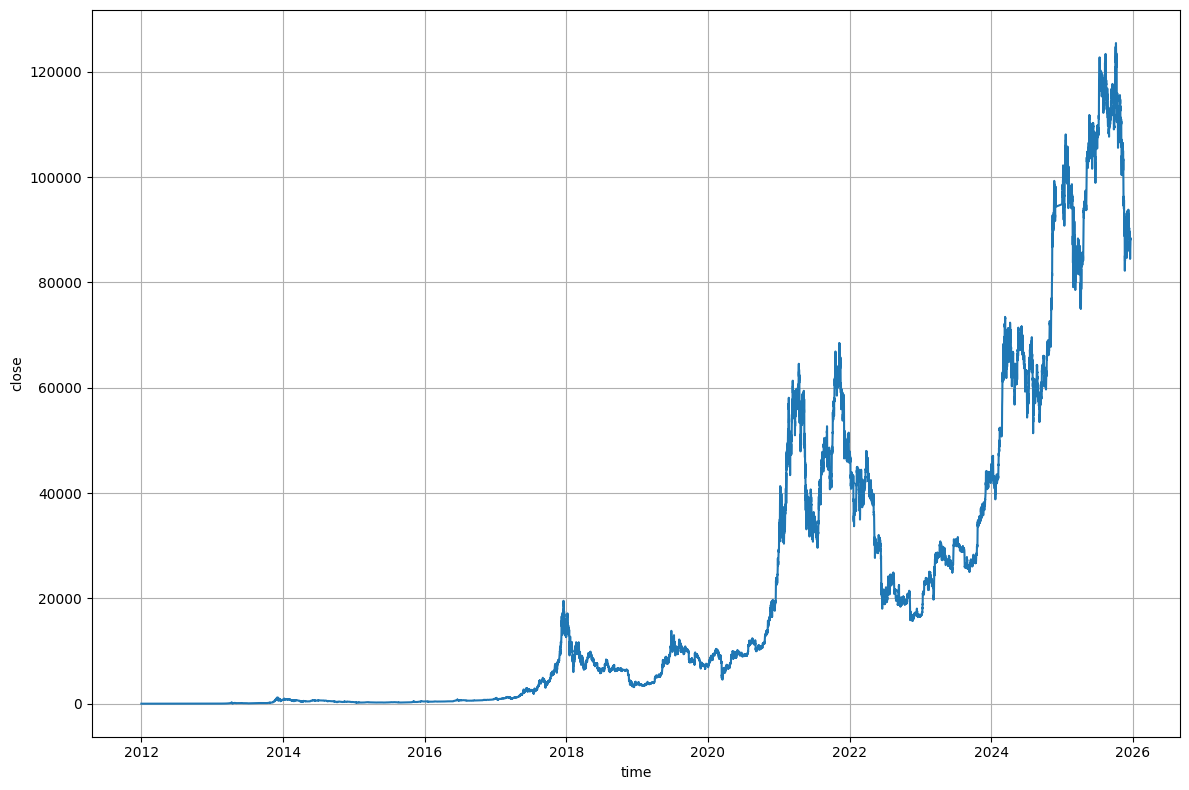

In [23]:
# Assign the datetime index
df.index=pd.DatetimeIndex(serie_time)
# Make sure the index has a name
df.index.name=time_column
if not df.index.is_monotonic_increasing:
    raise ValueError("Datetime index is not sorted")
if df.index.duplicated().any():
    raise ValueError("Datetime index has duplicates")
# Show preview
log(f"Indexed DataFrame by '{time_column}'")
log("Preview of time-indexed DataFrame:")
display(df.head(5))
log(f"Target column detected: '{target_column}'")
nan_target=df[target_column].isna().sum()
if nan_target>0:
    log(f"NaN values found in target '{target_column}': {nan_target} -> rows will be dropped for modeling", icon="WARNING")
else:
    log(f"None NaN values found in target '{target_column}'", icon="SUCCESS")
# Extract target timeseries
timeseries=df[target_column].dropna().astype(float)
log(f"Target column '{target_column}' ({len(timeseries)} rows) has been successfully extracted as time-series:", icon="SUCCESS")
display(timeseries.tail(5))

# Visualization plot
fig,axis=plt.subplots(figsize=(figWidth_unit,figHeight_unit))
sns.lineplot(data=timeseries)
plt.grid(True)
plt.tight_layout()
plt.show()

STEP 3) DECOMPOSE TIME-SERIES

• 🧠⏱️ AUTOMATIC DETERMINATION OF SEASONAL PERIOD (m):
   - ℹ️ 1st) Trying to infer period from manual input:
      · ⚠️ No manual input was indicated for seasonal period
   - ℹ️ 2nd) Trying to infer period from acf (n=30381 | candidates=[6, 42] | threshold=0.2):
      · ℹ️ After differentiation: n=30380
      · ℹ️ Lags: max_lag=84 (cap=400)
      · ℹ️ ACF at lag m=6: -0.0484
      · ℹ️ ACF at lag m=42: 0.0010
      · ℹ️ Best candidate: m=42 -> acf=0.0010
      · ⚠️ REJECT period inference from acf (best acf=0.0010 < 0.2) -> return None
   - ℹ️ 3rd) Fallback to infer period as first candidate based on granularity


   - ✅ Selected seasonal period (m)=6 for '4-hour' granularity


• ℹ️ GENERATION OF RETURNS (LOG-DIFF) FOR SEASONALITY DETECTION:
   - ✅ Returns generated: n=30380 (dropped 1 rows due to diff/log)
   - ✅ Returns decomposition completed successfully


• ℹ️ SEASONALITY STRENGTH METRICS BASED ON RETURNS:
   - ⚠️ Weak or no seasonality (var_ratio=0.000,acf=-0.032)
   - ℹ️ Recomme

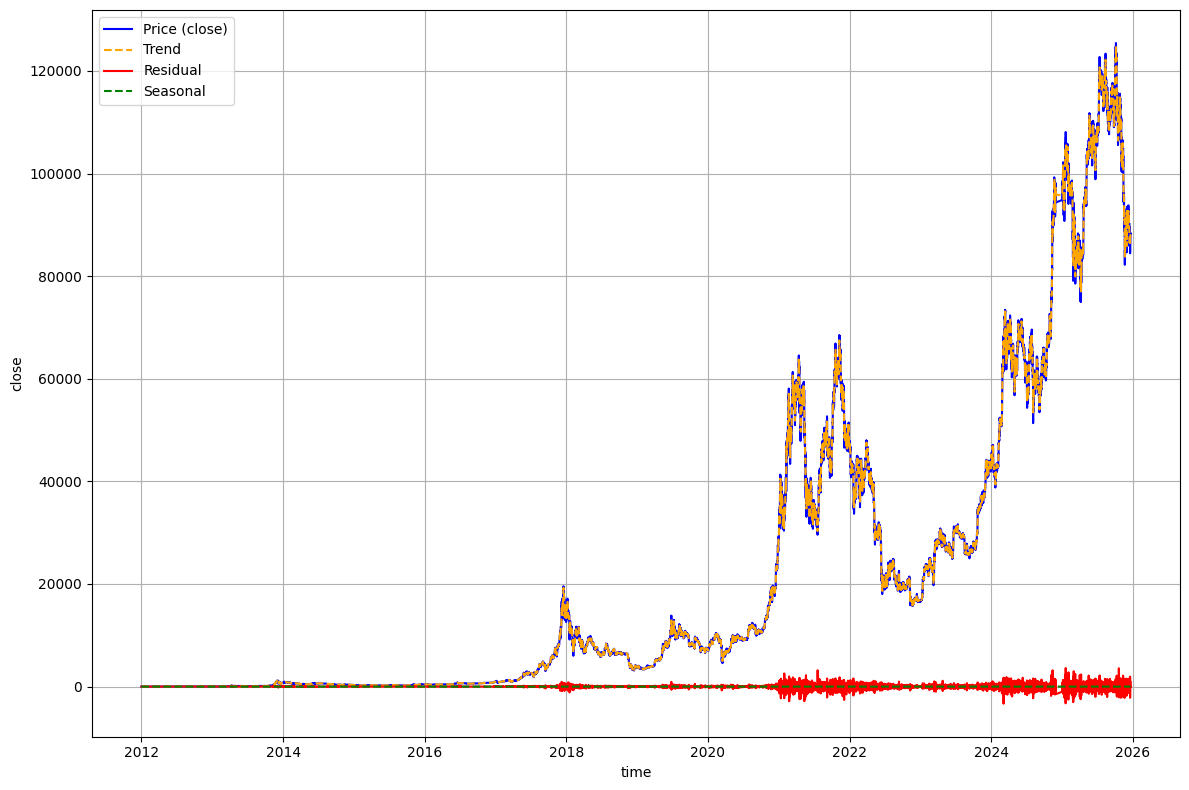

In [53]:
# Determine period
log(f"AUTOMATIC DETERMINATION OF SEASONAL PERIOD (m):", icon="🧠⏱️", bold=True)
period , period_origin =decide_seasonal_period(timeseries=timeseries,granularity=granularity,manual_period=seasonal_period) # manual_period can be set as e.g. 6/24/7/14
print("\n")
log(f"Selected seasonal period (m)={period} for '{granularity}' granularity",icon="SUCCESS", level=2, bold=True)

#Generate returns for robust seasonality detection (stationary-ish)
print("\n")
log(f"GENERATION OF RETURNS (LOG-DIFF) FOR SEASONALITY DETECTION:", bold=True)
if len(timeseries)<period*3:
    raise ValueError(f"Not enough samples for decomposition: n={len(timeseries)} < 3*period={period*3}")
returns=generate_returns(timeseries,method="log")
if len(returns)<period*3:
    raise ValueError(f"Not enough samples for returns decomposition: n={len(returns)} < 3*period={period*3}")
log(f"Returns generated: n={len(returns)} (dropped {len(timeseries)-len(returns)} rows due to diff/log)", icon="SUCCESS", level=2)

#Decompose RETURNS series for consistent seasonality strength metrics (all in returns units)
try:
    decomposition_ret=seasonal_decompose(x=returns,model="additive",period=period)
    trend_ret=decomposition_ret.trend
    seasonal_ret=decomposition_ret.seasonal
    residual_ret=decomposition_ret.resid
    log("Returns decomposition completed successfully", icon="SUCCESS", level=2)
except Exception as e:
    raise ValueError(f"Returns decomposition failed: {e}")

#Compute seasonality strength metrics on RETURNS decomposition (in returns units)
print("\n")
log(f"SEASONALITY STRENGTH METRICS BASED ON RETURNS:", bold=True)
strong_seasonality,seasonality_metrics_S3=assess_seasonality_strength(original=returns,seasonal=seasonal_ret,period=period,acf_threshold=0.2,var_ratio=0.02)
if strong_seasonality:
    log(f"Strong seasonality detected (var_ratio={seasonality_metrics_S3['seasonal_var_ratio']:.3f},acf={seasonality_metrics_S3['acf_at_period']:.3f})", icon="SUCCESS", level=2)
    log(f"Recommendation: try SARIMA with seasonal period m={period}", level=2)
else:
    log(f"Weak or no seasonality (var_ratio={seasonality_metrics_S3['seasonal_var_ratio']:.3f},acf={seasonality_metrics_S3['acf_at_period']:.3f})", icon="WARNING", level=2)
    log("Recommendation: ARIMA baseline (no clear seasonality detected)", level=2)

#Decompose PRICE series (close) for visualization (trend/seasonal/residual in price units)
print("\n")
log(f"DECOMPOSITION OF PRICE FOR VISUALIZATION:", bold=True)
try:
    decomposition_price=seasonal_decompose(x=timeseries,model="additive",period=period)
    trend_price=decomposition_price.trend
    seasonal_price=decomposition_price.seasonal
    residual_price=decomposition_price.resid
    log("Price decomposition completed successfully", icon="SUCCESS", level=2)
except Exception as e:
    raise ValueError(f"Price decomposition failed: {e}")

#Plot PRICE decomposition (visual understanding in price units)
fig,axis=plt.subplots(figsize=(figWidth_unit,figHeight_unit))
sns.lineplot(data=timeseries,color="blue",label="Price (close)")
sns.lineplot(data=trend_price,color="orange",label="Trend",linestyle="--")
sns.lineplot(data=residual_price,color="red",label="Residual")
sns.lineplot(data=seasonal_price,color="green",label="Seasonal",linestyle="--")
plt.grid(True)
plt.tight_layout()
plt.show()

STATIONARITY (ADF) -> INFER d AND D (FOR SARIMA)

In [67]:
#A) Infer non-seasonal differencing order d (for ARIMA/SARIMA)
series_adf_base=timeseries.dropna().astype(float)
adf_base=test_stationarity(series=series_adf_base)

log("DICKEY-FULLER TEST TO DETERMINE IF BASE SERIES IS STATIONARY", bold=True)
log(f"Results:\n{adf_base}", level=2)
if adf_base["p-value"]<accepted_alpha_dickey_fuller:
    d=0
    series_stationary_nonseasonal=series_adf_base
    log(f"Reject H0 (unit root) at alpha={accepted_alpha_dickey_fuller}: series IS stationary -> d={d}", icon="SUCCESS", level=2)
else:
    log(f"Fail to reject H0 (unit root) at alpha={accepted_alpha_dickey_fuller}: series is NOT stationary -> apply recursive differencing to infer d", icon="WARNING", level=2)
    series_stationary_nonseasonal,d,adf_after_diff=make_stationary_recursive(series=series_adf_base,alpha=accepted_alpha_dickey_fuller)
    log(f"RECURSIVE DIFFERENCING APPLIED: d={d}", bold=True)
    log(f"DICKEY-FULLER TEST TO DETERMINE IF SERIES IS STATIONARY AFTER {d} DIFFERENTIATION", bold=True)
    log(f"Results:\n{adf_after_diff}", level=2)
    if d>2:
        log(f"High differencing order detected (d={d}). This is unusual; consider log transform or returns-based modeling", icon="WARNING", level=2)
    if adf_after_diff["p-value"]<accepted_alpha_dickey_fuller:
        log(f"Reject H0 after differencing: stationary achieved with d={d}", icon="SUCCESS", level=2)
    else:
        log(f"Fail to reject H0 even after differencing up to d={d}: series may still be non-stationary or needs alternative transforms", icon="WARNING", level=2)

#B) Infer seasonal differencing order D (only meaningful when testing SARIMA)
D=0
seasonal_period_m=period
log(f"Seasonal period candidate m={seasonal_period_m} (from STEP 3)")
if seasonal_period_m is None or seasonal_period_m<=1:
    log("No valid seasonal period m provided -> skipping seasonal differencing inference (D=0)", icon="WARNING")
else:
    if not strong_seasonality:
        log("Seasonality strength is weak (from STEP 3) -> keep D=0 for baseline comparison (still allowed to test SARIMA later)", icon="WARNING", bold=True)
        D=0
    else:
        log("Seasonality strength is strong (from STEP 3) -> evaluating seasonal differencing D using ADF on d-differenced series", bold=True)
        series_for_D=series_adf_base.copy()
        if d>0:
            series_for_D=series_for_D.diff(d).dropna()
        if len(series_for_D)<max(60,seasonal_period_m*5):
            log("Not enough data after non-seasonal differencing to evaluate D reliably -> keep D=0", icon="WARNING")
            D=0
        else:
            log("ADF on series after non-seasonal differencing (reference check before adding seasonal differencing)", icon="INFO")
            adf_ref=test_stationarity(series=series_for_D)
            log(f"ADF results (after d={d}, no seasonal diff): {adf_ref}")
            log("ADF on series after non-seasonal + seasonal differencing (candidate D=1)")
            series_for_D_seasonal=series_for_D.diff(seasonal_period_m).dropna()
            if len(series_for_D_seasonal)<max(60,seasonal_period_m*5):
                log("Not enough data after adding seasonal differencing -> keep D=0", icon="WARNING")
                D=0
            else:
                adf_seasonal=test_stationarity(series=series_for_D_seasonal)
                log(f"ADF results (after d={d} and seasonal diff lag m): {adf_seasonal}")
                if adf_seasonal["p-value"]<accepted_alpha_dickey_fuller:
                    D=1
                    log(f"Reject H0 after adding seasonal differencing: seasonal stationarity improved -> suggest D={D}", icon="SUCCESS", bold=True)
                else:
                    D=0
                    log(f"Fail to reject H0 after adding seasonal differencing: no clear benefit -> suggest D={D}", icon="WARNING", bold=True)
#C) Final logging: recommended model families (parameters to be tuned later)
log("Model family recommendation (orders to tune later with AIC/BIC/backtesting)", bold=True)
log(f"ARIMA baseline structure: (p,d,q) with d={d}", bold=True)
log(f"SARIMA candidate structure: (p,d,q)(P,D,Q,m) with d={d},D={D},m={seasonal_period_m}", bold=True)


• ℹ️ DICKEY-FULLER TEST TO DETERMINE IF BASE SERIES IS STATIONARY
   - ℹ️ Results:
Test Statistic                    -0.079639
p-value                            0.951429
#Lags Used                        49.000000
Number of Observations Used    30331.000000
Critical Value (1%)               -3.430566
Critical Value (5%)               -2.861635
Critical Value (10%)              -2.566821
dtype: float64
   - ⚠️ Fail to reject H0 (unit root) at alpha=0.05: series is NOT stationary -> apply recursive differencing to infer d
• ℹ️ RECURSIVE DIFFERENCING APPLIED: d=1
• ℹ️ DICKEY-FULLER TEST TO DETERMINE IF SERIES IS STATIONARY AFTER 1 DIFFERENTIATION
   - ℹ️ Results:
Test Statistic                   -25.550945
p-value                            0.000000
#Lags Used                        48.000000
Number of Observations Used    30331.000000
Critical Value (1%)               -3.430566
Critical Value (5%)               -2.861635
Critical Value (10%)              -2.566821
dtype: float64
   - ✅ 

STEP 5) RESIDUAL DIAGNOSTICS (DECOMPOSITION-BASED) -> SHOULD LOOK LIKE WHITE NOISE

In [68]:
#Use RETURNS residuals as primary diagnostics (consistent with seasonality strength logic)
residual_S5=residual_ret.dropna().astype(float)
log(f"Residual series selected: RETURNS residuals (n={len(residual_S5)})")
#Safety: need enough points for diagnostics
if len(residual_S5)<50:
    log("Not enough residual points for robust diagnostics (n<50). Skipping residual checks.", icon="WARNING", bold=True)
else:
    # -------------------------------------------
    #RULE A: Check for visible trend in residuals (slope ~ 0)
    # -------------------------------------------
    x_index=np.arange(len(residual_S5))
    slope,intercept=np.polyfit(x_index,residual_S5.values,1)
    residual_std=np.std(residual_S5.values)
    if residual_std<1e-8:
        log("Residual slope analysis: residuals are almost constant -> no visible trend (good)", icon="SUCCESS")
    else:
        if abs(slope)<max(residual_std*0.01,1e-6):
            log(f"Residual slope analysis: no visible trend (slope={slope:.3e}) (good)", icon="SUCCESS")
        else:
            log(f"Residual slope analysis: trend detected (slope={slope:.3e}) (bad)", icon="WARNING",bold=True)
    # -------------------------------------------
    #RULE B: Check periodicity using ACF (should NOT show strong peaks)
    # -------------------------------------------
    if residual_std<1e-8:
        log("Residual ACF analysis: residuals almost constant -> no periodicity possible (good)", icon="SUCCESS")
    else:
        nlags=min(max(10,2*period),min(80,len(residual_S5)-2))
        if nlags<5:
            log("Residual ACF analysis: not enough points to compute ACF reliably", icon="WARNING")
        else:
            acf_res=acf(residual_S5,nlags=nlags,fft=True,missing="drop")
            acf_res_no0=acf_res[1:]
            max_acf_lag=np.argmax(np.abs(acf_res_no0))+1
            max_acf_value=acf_res[max_acf_lag]
            log(f"Residual ACF strongest lag={max_acf_lag},value={max_acf_value:.3f}")
            if np.isnan(max_acf_value):
                log("Residual ACF analysis: ACF could not be computed reliably -> assume no periodicity (good)", icon="SUCCESS")
            elif abs(max_acf_value)<0.3:
                log("Residual ACF analysis: no meaningful periodic patterns detected (good)", icon="SUCCESS")
            else:
                log("Residual ACF analysis: periodic pattern detected in residuals (bad)", icon="WARNING",bold=True)
    # -------------------------------------------
    # RULE C: Check residuals are centered (mean ~ 0 for additive)
    # -------------------------------------------
    residual_center=0.0
    mean_res=residual_S5.mean()
    sd_res=residual_S5.std()
    threshold_center=max(sd_res*0.05,1e-6)
    if abs(mean_res-residual_center)<threshold_center:
        log(f"Residual center analysis: centered around {residual_center} (mean={mean_res:.3e}) (good)", icon="SUCCESS")
    else:
        log(f"Residual center analysis: not well centered (mean={mean_res:.3e}) (bad)", icon="WARNING")
    # -------------------------------------------
    # RULE D: Randomness / autocorrelation using Ljung–Box (want p > 0.05)
    # -------------------------------------------
    # Center residuals (0 for additive, 1 for multiplicative already handled before)
    residual_centered=residual_S5-residual_center
    sd_centered=residual_centered.std()

    # If residuals are almost constant → cannot test randomness, assume GOOD
    if sd_centered<1e-8:
        log("Residual randomness analysis: residuals almost constant -> assume random (good)", icon="SUCCESS")
    else:
        # Get interpretable lags based on granularity
        test_lags=lag_candidates_from_granularity(granularity)
        # Keep only safe lags
        test_lags=[l for l in test_lags if 2<=l<len(residual_centered)-2]

        if not test_lags:
            log("Residual randomness analysis: no valid lags available for Ljung-Box", icon="WARNING")
        else:
            # Ljung–Box on residuals
            lb_df=acorr_ljungbox(residual_centered,lags=test_lags,return_df=True)
            for L in test_lags:
                pval=float(lb_df.loc[L,"lb_pvalue"])
                log(f"Ljung-Box p-value (lag {L})={pval:.4f}")

            if (lb_df["lb_pvalue"]>0.05).all():
                log("Residual randomness analysis: residuals behave like white noise (good)", icon="SUCCESS")
            else:
                log("Residual randomness analysis: residuals show autocorrelation (bad)", icon="WARNING",bold=True)

            # Optional: volatility clustering check (ARCH/GARCH hint)
            lb_abs=acorr_ljungbox(np.abs(residual_centered),lags=test_lags,return_df=True)
            if (lb_abs["lb_pvalue"]<=0.05).any():
                log("Volatility effect detected: |residuals| are autocorrelated (ARCH/GARCH-like behavior)", icon="WARNING",bold=True)


• ℹ️ Residual series selected: RETURNS residuals (n=30374)
• ✅ Residual slope analysis: no visible trend (slope=7.346e-11) (good)
• ℹ️ Residual ACF strongest lag=2,value=-0.273
• ✅ Residual ACF analysis: no meaningful periodic patterns detected (good)
• ✅ Residual center analysis: centered around 0.0 (mean=-3.219e-07) (good)
• ℹ️ Ljung-Box p-value (lag 2)=0.0000
• ℹ️ Ljung-Box p-value (lag 3)=0.0000
• ℹ️ Ljung-Box p-value (lag 6)=0.0000
• ℹ️ Ljung-Box p-value (lag 12)=0.0000
• ℹ️ Ljung-Box p-value (lag 42)=0.0000
• ⚠️ Residual randomness analysis: residuals show autocorrelation (bad)
• ⚠️ Volatility effect detected: |residuals| are autocorrelated (ARCH/GARCH-like behavior)


STEP 6) ACF/PACF DIAGNOSTICS + ORDER SUGGESTIONS (ARIMA vs SARIMA)

   - ✅ Applied pandas frequency '4h' for diagnostics.
   - ℹ️ Diagnostics series prepared with non-seasonal differencing d=1 (n=30373)
   - ℹ️ Using safe_lag=42 (n=30373, conf≈±0.011)
   - ℹ️ ACF: first significant lag=1 -> q≈1 candidate
   - ℹ️ PACF: first significant lag=1 -> p≈1 candidate


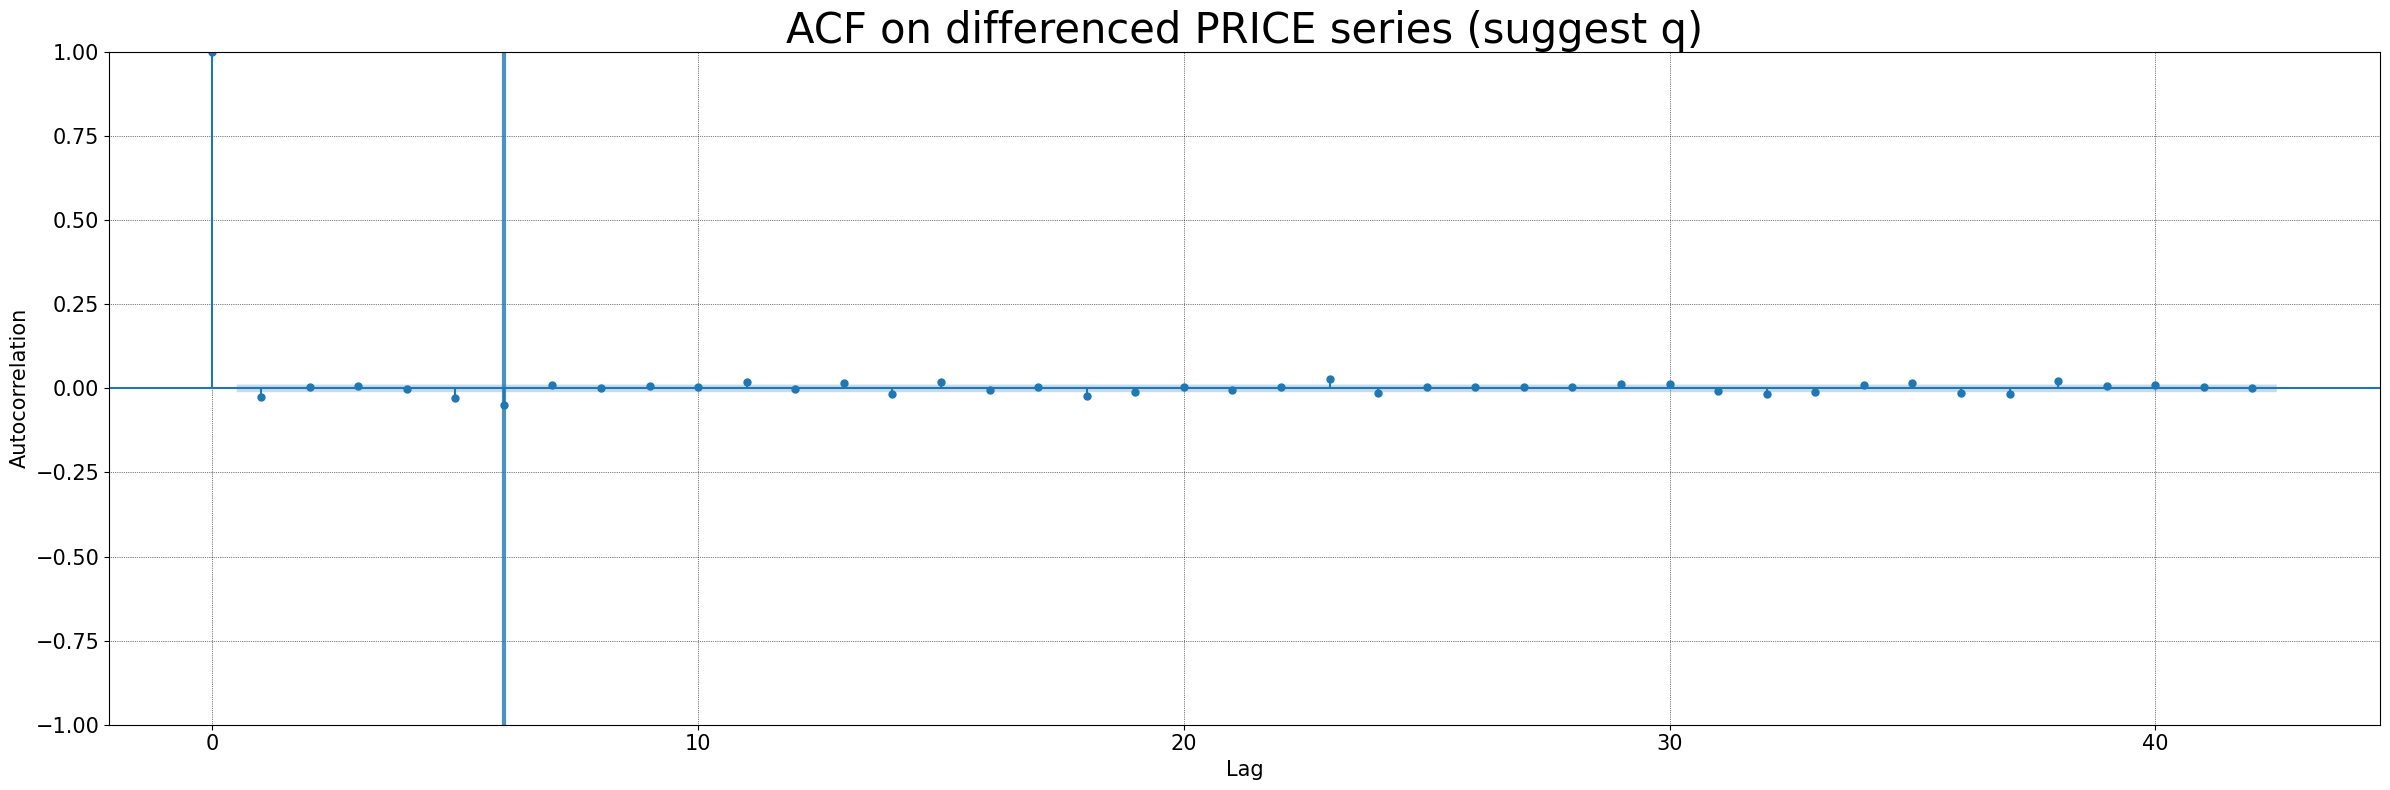

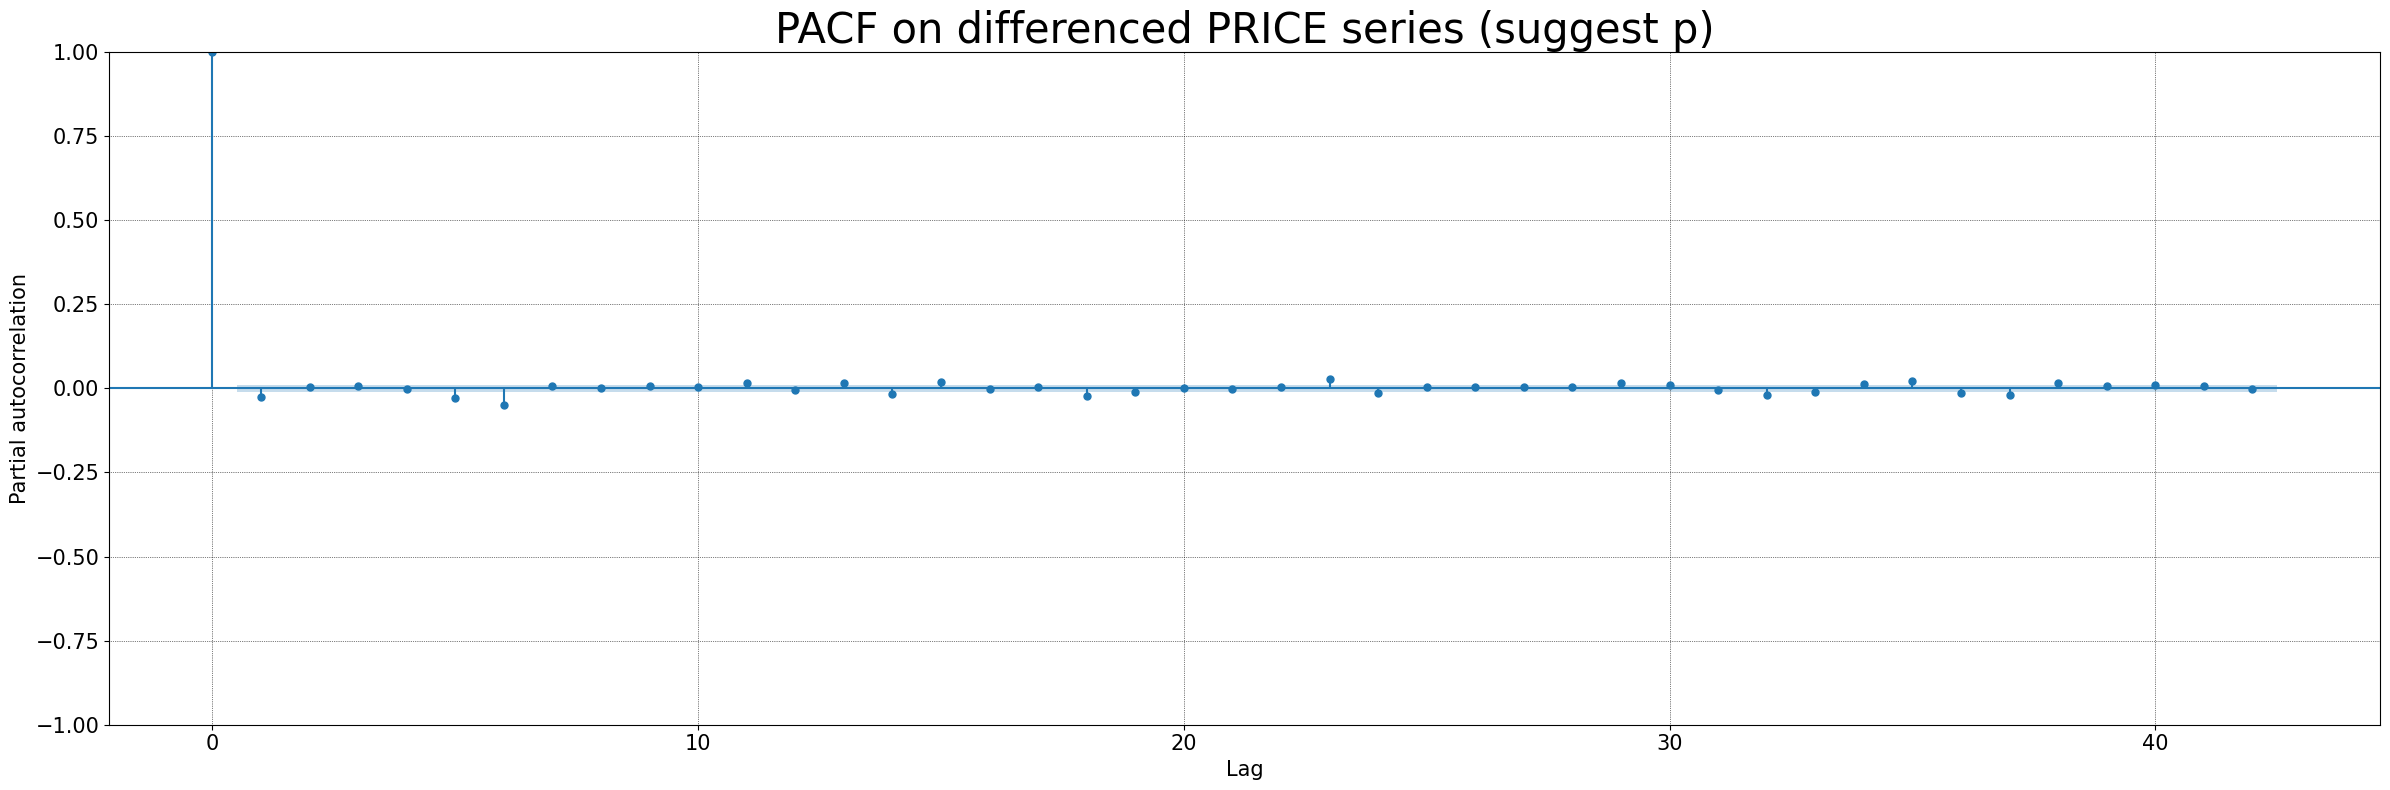

   - ⚠️ Seasonal order suggestion: weak seasonality -> keep P=0,Q=0 (still you can test SARIMA later).


• ℹ️ ORDER SUGGESTIONS SUMMARY:
   - ℹ️ ARIMA suggestion: (p,d,q)=(1,1,1)
   - ℹ️ SARIMA suggestion: (p,d,q)(P,D,Q,m)=(1,1,1)(0,0,0,6)
   - ℹ️ ARIMA candidate grid size=4 -> examples: [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1)]
   - ℹ️ SARIMA candidate grid size=16 -> examples: [(0, 1, 0, 0, 0, 0, 6), (0, 1, 0, 0, 0, 1, 6), (0, 1, 0, 1, 0, 0, 6), (0, 1, 0, 1, 0, 1, 6), (0, 1, 1, 0, 0, 0, 6), (0, 1, 1, 0, 0, 1, 6), (0, 1, 1, 1, 0, 0, 6), (0, 1, 1, 1, 0, 1, 6)]


In [69]:
# -------------------------------
# Prepare diagnostics series in PRICE units, but differenced to be closer to stationary
# -------------------------------
series_for_diag=timeseries.dropna().astype(float).copy()
freq=get_pandas_freq_from_granularity(granularity)
if freq is not None:
    try:
        series_for_diag=series_for_diag.asfreq(freq)
        log(f"Applied pandas frequency '{freq}' for diagnostics.",icon="SUCCESS",level=2)
    except Exception as e:
        log(f"Could not apply pandas frequency '{freq}': {e}",icon="WARNING",level=2)
else:
    log(f"No pandas freq mapping for granularity='{granularity}' -> skipping asfreq.",icon="WARNING",level=2)

# Non-seasonal differencing for ARIMA diagnostics (use d from STEP 4)
series_diag_ns=series_for_diag.copy()
if d>0:
    series_diag_ns=series_diag_ns.diff(d).dropna()
log(f"Diagnostics series prepared with non-seasonal differencing d={d} (n={len(series_diag_ns)})",icon="INFO",level=2)

# Default suggestions
suggested_p=0
suggested_q=0
suggested_P=0
suggested_Q=0

# If series is almost constant -> no meaningful ACF/PACF
if len(series_diag_ns)<30 or series_diag_ns.std()<1e-8:
    log("ACF/PACF analysis: differenced series too short or almost constant -> default p=q=0.",icon="WARNING",level=2)
else:
    n=len(series_diag_ns)
    safe_lag=get_safe_lag_for_acf_pacf(granularity,period,n,max_cap=300)
    conf_limit=1.96/np.sqrt(n)
    log(f"Using safe_lag={safe_lag} (n={n}, conf≈±{conf_limit:.3f})",icon="INFO",level=2)

    # -------------------------------
    # ACF/PACF on non-seasonal differenced series -> suggest (p,q)
    # -------------------------------
    ac_vals=acf(series_diag_ns,nlags=safe_lag,fft=True,missing="drop")
    pc_vals=pacf(series_diag_ns,nlags=safe_lag,method="ywm")
    sig_acf=[lag for lag in range(1,len(ac_vals)) if abs(ac_vals[lag])>conf_limit]
    sig_pacf=[lag for lag in range(1,len(pc_vals)) if abs(pc_vals[lag])>conf_limit]

    if len(sig_acf)==0:
        suggested_q=0
        log("ACF: no significant lags -> q≈0 candidate",icon="INFO",level=2)
    else:
        suggested_q=int(sig_acf[0])
        log(f"ACF: first significant lag={suggested_q} -> q≈{suggested_q} candidate",icon="INFO",level=2)

    if len(sig_pacf)==0:
        suggested_p=0
        log("PACF: no significant lags -> p≈0 candidate",icon="INFO",level=2)
    else:
        suggested_p=int(sig_pacf[0])
        log(f"PACF: first significant lag={suggested_p} -> p≈{suggested_p} candidate",icon="INFO",level=2)

    # -------------------------------
    # Plot ACF/PACF (non-seasonal diagnostics)
    # -------------------------------
    fig_acf,ax_acf=plt.subplots(figsize=(2*figWidth_unit,1*figHeight_unit))
    plot_acf(series_diag_ns,lags=safe_lag,ax=ax_acf)
    ax_acf.set_title("ACF on differenced PRICE series (suggest q)",fontsize=plot_title_font_size)
    ax_acf.set_xlabel("Lag",fontsize=plot_label_font_size)
    ax_acf.set_ylabel("Autocorrelation",fontsize=plot_label_font_size)
    ax_acf.tick_params(labelsize=plot_tick_font_size)
    ax_acf.grid(True,linestyle="dotted",linewidth=0.5,color="black")
    if period is not None and period>1 and period<=safe_lag:
        ax_acf.axvline(x=period,linewidth=3,alpha=0.8)
    plt.tight_layout()
    plt.show()

    fig_pacf,ax_pacf=plt.subplots(figsize=(2*figWidth_unit,1*figHeight_unit))
    plot_pacf(series_diag_ns,lags=safe_lag,ax=ax_pacf,method="ywm")
    ax_pacf.set_title("PACF on differenced PRICE series (suggest p)",fontsize=plot_title_font_size)
    ax_pacf.set_xlabel("Lag",fontsize=plot_label_font_size)
    ax_pacf.set_ylabel("Partial autocorrelation",fontsize=plot_label_font_size)
    ax_pacf.tick_params(labelsize=plot_tick_font_size)
    ax_pacf.grid(True,linestyle="dotted",linewidth=0.5,color="black")
    plt.tight_layout()
    plt.show()

    # -------------------------------
    # Seasonal ACF/PACF -> suggest (P,Q) only if seasonality is plausible
    # -------------------------------
    suggested_P=0
    suggested_Q=0
    if period is None or period<=1:
        log("Seasonal order suggestion skipped: invalid seasonal period m.",icon="WARNING",level=2)
    else:
        if not strong_seasonality:
            log("Seasonal order suggestion: weak seasonality -> keep P=0,Q=0 (still you can test SARIMA later).",icon="WARNING",level=2)
        else:
            series_diag_s=series_diag_ns.copy()
            if D>0:
                series_diag_s=series_diag_s.diff(period).dropna()
            log(f"Seasonal diagnostics series prepared with D={D} and m={period} (n={len(series_diag_s)})",icon="INFO",level=2)

            if len(series_diag_s)<max(60,period*5):
                log("Not enough points for seasonal ACF/PACF -> keep P=0,Q=0.",icon="WARNING",level=2)
            else:
                safe_lag_s=int(min(max(2*period,60),len(series_diag_s)-2,400))
                conf_limit_s=1.96/np.sqrt(len(series_diag_s))
                ac_s=acf(series_diag_s,nlags=safe_lag_s,fft=True,missing="drop")
                pc_s=pacf(series_diag_s,nlags=safe_lag_s,method="ywm")

                seasonal_lags=[k*period for k in range(1,(safe_lag_s//period)+1)]
                sig_seasonal_acf=[L for L in seasonal_lags if L<len(ac_s) and abs(ac_s[L])>conf_limit_s]
                sig_seasonal_pacf=[L for L in seasonal_lags if L<len(pc_s) and abs(pc_s[L])>conf_limit_s]

                if len(sig_seasonal_acf)>0:
                    suggested_Q=1
                    log(f"Seasonal ACF: significant at lag {int(sig_seasonal_acf[0])} -> Q≈1 candidate",icon="INFO",level=2)
                else:
                    suggested_Q=0
                    log("Seasonal ACF: no significant seasonal multiples -> Q≈0 candidate",icon="INFO",level=2)

                if len(sig_seasonal_pacf)>0:
                    suggested_P=1
                    log(f"Seasonal PACF: significant at lag {int(sig_seasonal_pacf[0])} -> P≈1 candidate",icon="INFO",level=2)
                else:
                    suggested_P=0
                    log("Seasonal PACF: no significant seasonal multiples -> P≈0 candidate",icon="INFO",level=2)

                fig_acf_s,ax_acf_s=plt.subplots(figsize=(2*figWidth_unit,1*figHeight_unit))
                plot_acf(series_diag_s,lags=safe_lag_s,ax=ax_acf_s)
                ax_acf_s.set_title("ACF on (d + seasonal) differenced PRICE series (suggest Q)",fontsize=plot_title_font_size)
                ax_acf_s.set_xlabel("Lag",fontsize=plot_label_font_size)
                ax_acf_s.set_ylabel("Autocorrelation",fontsize=plot_label_font_size)
                ax_acf_s.tick_params(labelsize=plot_tick_font_size)
                ax_acf_s.grid(True,linestyle="dotted",linewidth=0.5,color="black")
                ax_acf_s.axvline(x=period,linewidth=3,alpha=0.8)
                plt.tight_layout()
                plt.show()

                fig_pacf_s,ax_pacf_s=plt.subplots(figsize=(2*figWidth_unit,1*figHeight_unit))
                plot_pacf(series_diag_s,lags=safe_lag_s,ax=ax_pacf_s,method="ywm")
                ax_pacf_s.set_title("PACF on (d + seasonal) differenced PRICE series (suggest P)",fontsize=plot_title_font_size)
                ax_pacf_s.set_xlabel("Lag",fontsize=plot_label_font_size)
                ax_pacf_s.set_ylabel("Partial autocorrelation",fontsize=plot_label_font_size)
                ax_pacf_s.tick_params(labelsize=plot_tick_font_size)
                ax_pacf_s.grid(True,linestyle="dotted",linewidth=0.5,color="black")
                ax_pacf_s.axvline(x=period,linewidth=3,alpha=0.8)
                plt.tight_layout()
                plt.show()

# -------------------------------
# Final suggestions logging
# -------------------------------
print("\n")
log("ORDER SUGGESTIONS SUMMARY:",bold=True)
log(f"ARIMA suggestion: (p,d,q)=({suggested_p},{d},{suggested_q})",icon="INFO",level=2)
log(f"SARIMA suggestion: (p,d,q)(P,D,Q,m)=({suggested_p},{d},{suggested_q})({suggested_P},{D},{suggested_Q},{period})",icon="INFO",level=2)

# -------------------------------
# Build small, coherent grids for the next STEP (model search/backtesting)
# -------------------------------
arima_grid=[]
for p_try in sorted(list(set([0,1,suggested_p]))):
    for q_try in sorted(list(set([0,1,suggested_q]))):
        arima_grid.append((p_try,d,q_try))
sarima_grid=[]
for p_try in sorted(list(set([0,1,suggested_p]))):
    for q_try in sorted(list(set([0,1,suggested_q]))):
        for P_try in sorted(list(set([0,1,suggested_P]))):
            for Q_try in sorted(list(set([0,1,suggested_Q]))):
                sarima_grid.append((p_try,d,q_try,P_try,D,Q_try,period))
log(f"ARIMA candidate grid size={len(arima_grid)} -> examples: {arima_grid[:8]}",icon="INFO",level=2)
log(f"SARIMA candidate grid size={len(sarima_grid)} -> examples: {sarima_grid[:8]}",icon="INFO",level=2)


STEP 7) TIME SERIES TRAIN/TEST SPLIT + NAIVE BASELINE

In [ ]:
# Split configuration
split_idx=int(len(timeseries)*(1.0-test_size))
timeseries_train=timeseries.iloc[:split_idx].copy()
timeseries_test=timeseries.iloc[split_idx:].copy()
log(f"Split done: train={len(timeseries_train)} rows, test={len(timeseries_test)} rows (test_ratio≈{len(timeseries_test)/len(timeseries):.2f})",type="SUCCESS",bold=True)
log(f"Train range: {timeseries_train.index.min()} -> {timeseries_train.index.max()}",level=2,type="INFO")
log(f"Test range:  {timeseries_test.index.min()} -> {timeseries_test.index.max()}",level=2,type="INFO")
# Naive baseline (persistence): y_hat[t]=y[t-1]
log("Building naive baseline (persistence): y_hat[t]=y[t-1]",type="INFO",bold=True)
naive_pred=timeseries_test.shift(1)
# First test prediction uses last train value (bridging gap)
if len(timeseries_train)>0 and len(naive_pred)>0:
    naive_pred.iloc[0]=timeseries_train.iloc[-1]
# Align and drop NaNs (defensive)
y_true=timeseries_test.copy()
y_pred_naive=naive_pred.copy()
mask_valid_y=y_true.notna() & y_pred_naive.notna()
y_true=y_true.loc[mask_valid_y]
y_pred_naive=y_pred_naive.loc[mask_valid_y]
if len(y_true)<10:
    raise ValueError("Not enough points to evaluate naive baseline after alignment")
# Metrics helpers (local, minimal)
def mae(y_true: pd.Series,y_pred: pd.Series)->float:
    return float(np.mean(np.abs(y_true.values-y_pred.values)))
def rmse(y_true: pd.Series,y_pred: pd.Series)->float:
    return float(np.sqrt(np.mean((y_true.values-y_pred.values)**2)))
def mase(y_true: pd.Series,y_pred: pd.Series,y_train: pd.Series)->float:
    y_train=y_train.dropna().astype(float)
    if len(y_train)<2:
        return np.nan
    naive_in_sample=np.abs(y_train.diff().dropna()).mean()
    if naive_in_sample==0:
        return np.nan
    return float(np.mean(np.abs(y_true.values-y_pred.values))/naive_in_sample)
# Compute baseline metrics
mae_naive=mae(y_true,y_pred_naive)
rmse_naive=rmse(y_true,y_pred_naive)
mase_naive=mase(y_true,y_pred_naive,timeseries_train)
log("Naive baseline metrics (to beat)",type="INFO",bold=True)
log(f"MAE  (naive) = {mae_naive:.6f}",level=2,type="INFO")
log(f"RMSE (naive) = {rmse_naive:.6f}",level=2,type="INFO")
log(f"MASE (naive) = {mase_naive:.6f}",level=2,type="INFO")
# Quick plot: train/test + naive predictions
log("Plotting train/test split + naive baseline predictions",type="INFO")
fig,axis=plt.subplots(figsize=(2*figWidth_unit,figHeight_unit))
sns.lineplot(x=timeseries_train.index,y=timeseries_train.values,label="Train")
sns.lineplot(x=timeseries_test.index,y=timeseries_test.values,label="Test",color="green")
sns.lineplot(x=y_pred_naive.index,y=y_pred_naive.values,label="Naive (t-1)", color="red", alpha=0.4 , linewidth=3)
plt.grid(True)
plt.tight_layout()
plt.show()

# ===============================
# BUILD FILENAMES WITH REVISION NUMBER
# ===============================
rev_number = get_revision_number(processed_data_output_path, "timeseries_train")
output_path_train = processed_data_output_path + "timeseries_train" + "_" + str(rev_number) + ".csv"
output_path_test = processed_data_output_path + "timeseries_test" + "_" + str(rev_number) + ".csv"

# ===============================
# SAVE ALL DATASETS
# ===============================
timeseries_train.to_csv(output_path_train, index=True)
log(f"timeseries_train saved in {processed_data_output_path} with revision number: {rev_number}", type="SUCCESS")
timeseries_test.to_csv(output_path_test, index=True)
log(f"timeseries_test saved in {processed_data_output_path} with revision number: {rev_number}", type="SUCCESS")

In [ ]:
# ===============================
# STEP 7) TRAIN + EVALUATE ARIMA vs SARIMA (vs Naive Baseline)
# - Fit on train
# - Forecast exactly the test horizon
# - Compare metrics against naive baseline (STEP 6)
# ===============================
log("===============================",type="INFO",bold=True)
log("STEP 7) ARIMA vs SARIMA (train -> forecast test) + compare vs Naive",type="INFO",bold=True)
log("===============================",type="INFO",bold=True)
# ===============================
# Imports (keep here if this is a standalone notebook cell)
# ===============================
from statsmodels.tsa.statespace.sarimax import SARIMAX
# ===============================
# Defensive checks
# ===============================
if not isinstance(timeseries_train.index,pd.DatetimeIndex) or not isinstance(timeseries_test.index,pd.DatetimeIndex):
    raise ValueError("Train/Test series must have a DatetimeIndex (check STEP 2 and STEP 6 CSV saving/loading).")
if len(timeseries_train)<max(50,period*5):
    log("Train set is relatively small for seasonal modeling; SARIMA may be unstable.",type="WARNING",bold=True)
h=len(timeseries_test)
if h<10:
    raise ValueError("Test horizon too small to evaluate models reliably (need >=10).")
# ===============================
# Helper: fit+forecast (ARIMA or SARIMA via SARIMAX)
# ===============================
def fit_forecast_sarimax(y_train:pd.Series,order:tuple[int,int,int],seasonal_order:tuple[int,int,int,int]|None,forecast_steps:int)->pd.Series:
    if seasonal_order is None:
        seasonal_order=(0,0,0,0)
    model=SARIMAX(endog=y_train,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
    res=model.fit(disp=False)
    fc=res.get_forecast(steps=forecast_steps).predicted_mean
    fc=pd.Series(fc.values,index=timeseries_test.index,name="forecast")
    return res,fc
# ===============================
# Order search (small grid, robust)
# - We already inferred d and D in STEP 4
# - We already inferred m=period in STEP 3
# ===============================
p_grid=[0,1,2]
q_grid=[0,1,2]
P_grid=[0,1,2]
Q_grid=[0,1,2]
log("Selecting orders via small AIC grid-search on TRAIN (keeps d/D/m fixed)",type="INFO",bold=True)
# -------------------------------
# ARIMA grid-search (p,d,q) only
# -------------------------------
best_arima_aic=np.inf
best_arima_order=None
best_arima_res=None
for p_try in p_grid:
    for q_try in q_grid:
        try:
            res_try=SARIMAX(endog=timeseries_train,order=(p_try,d,q_try),seasonal_order=(0,0,0,0),enforce_stationarity=False,enforce_invertibility=False).fit(disp=False)
            if res_try.aic<best_arima_aic:
                best_arima_aic=res_try.aic
                best_arima_order=(p_try,d,q_try)
                best_arima_res=res_try
        except Exception as e:
            log(f"ARIMA({p_try},{d},{q_try}) failed: {e}",level=2,type="WARNING")
if best_arima_order is None:
    raise ValueError("ARIMA grid-search failed for all candidates.")
log(f"Best ARIMA by AIC on TRAIN: order={best_arima_order}, AIC={best_arima_aic:.2f}",type="SUCCESS",bold=True)
# -------------------------------
# SARIMA grid-search (p,d,q)(P,D,Q,m) only if m is valid
# -------------------------------
best_sarima_aic=np.inf
best_sarima_order=None
best_sarima_seasonal=None
best_sarima_res=None
if period is None or period<=1:
    log("No valid seasonal period m -> SARIMA skipped (will compare ARIMA vs Naive only)",type="WARNING",bold=True)
else:
    if not strong_seasonality:
        log("Seasonality flagged as weak (STEP 3) -> SARIMA is still tested for comparison, but may not win.",type="WARNING",bold=True)
    for p_try in p_grid:
        for q_try in q_grid:
            for P_try in P_grid:
                for Q_try in Q_grid:
                    try:
                        res_try=SARIMAX(endog=timeseries_train,order=(p_try,d,q_try),seasonal_order=(P_try,D,Q_try,period),enforce_stationarity=False,enforce_invertibility=False).fit(disp=False)
                        if res_try.aic<best_sarima_aic:
                            best_sarima_aic=res_try.aic
                            best_sarima_order=(p_try,d,q_try)
                            best_sarima_seasonal=(P_try,D,Q_try,period)
                            best_sarima_res=res_try
                    except Exception as e:
                        log(f"SARIMA({p_try},{d},{q_try})({P_try},{D},{Q_try},{period}) failed: {e}",level=3,type="WARNING")
    if best_sarima_order is None:
        log("SARIMA grid-search failed for all candidates -> SARIMA will be skipped.",type="WARNING",bold=True)
    else:
        log(f"Best SARIMA by AIC on TRAIN: order={best_sarima_order}, seasonal={best_sarima_seasonal}, AIC={best_sarima_aic:.2f}",type="SUCCESS",bold=True)
# ===============================
# Forecast TEST horizon
# ===============================
log(f"Forecasting TEST horizon: h={h} steps",type="INFO",bold=True)
# ARIMA forecast (use best_arima_res if available, else refit)
try:
    if best_arima_res is not None:
        arima_fc=best_arima_res.get_forecast(steps=h).predicted_mean
        arima_pred=pd.Series(arima_fc.values,index=timeseries_test.index,name="arima_pred")
    else:
        _,arima_pred=fit_forecast_sarimax(timeseries_train,order=best_arima_order,seasonal_order=None,forecast_steps=h)
        arima_pred.name="arima_pred"
    log("ARIMA forecast generated successfully",type="SUCCESS")
except Exception as e:
    raise ValueError(f"ARIMA forecast failed: {e}")
# SARIMA forecast (if available)
sarima_pred=None
if best_sarima_order is not None and best_sarima_seasonal is not None:
    try:
        if best_sarima_res is not None:
            sarima_fc=best_sarima_res.get_forecast(steps=h).predicted_mean
            sarima_pred=pd.Series(sarima_fc.values,index=timeseries_test.index,name="sarima_pred")
        else:
            _,sarima_pred=fit_forecast_sarimax(timeseries_train,order=best_sarima_order,seasonal_order=best_sarima_seasonal,forecast_steps=h)
            sarima_pred.name="sarima_pred"
        log("SARIMA forecast generated successfully",type="SUCCESS")
    except Exception as e:
        log(f"SARIMA forecast failed: {e}",type="WARNING",bold=True)
        sarima_pred=None
# ===============================
# Evaluate metrics (same alignment logic as baseline)
# ===============================
def align_true_pred(y_true:pd.Series,y_pred:pd.Series)->tuple[pd.Series,pd.Series]:
    mask=y_true.notna() & y_pred.notna()
    y_true2=y_true.loc[mask].copy()
    y_pred2=y_pred.loc[mask].copy()
    return y_true2,y_pred2
y_true_test=timeseries_test.copy()
# Naive metrics (already computed in STEP 6, but recompute defensively for fair comparison)
y_true_naive,y_pred_naive=align_true_pred(timeseries_test,y_pred_naive_S6)
mae_naive=mae(y_true_naive,y_pred_naive)
rmse_naive=rmse(y_true_naive,y_pred_naive)
mase_naive=mase(y_true_naive,y_pred_naive,timeseries_train)
# ARIMA metrics
y_true_arima,y_pred_arima=align_true_pred(y_true_test,arima_pred)
mae_arima=mae(y_true_arima,y_pred_arima)
rmse_arima=rmse(y_true_arima,y_pred_arima)
mase_arima=mase(y_true_arima,y_pred_arima,timeseries_train)
# SARIMA metrics (if available)
if sarima_pred is not None:
    y_true_sarima,y_pred_sarima=align_true_pred(y_true_test,sarima_pred)
    mae_sarima=mae(y_true_sarima,y_pred_sarima)
    rmse_sarima=rmse(y_true_sarima,y_pred_sarima)
    mase_sarima=mase(y_true_sarima,y_pred_sarima,timeseries_train)
else:
    mae_sarima=rmse_sarima=mase_sarima=np.nan
# ===============================
# Log results + winners
# ===============================
log("Evaluation on TEST (lower is better)",type="INFO",bold=True)
log(f"NAIVE  -> MAE={mae_naive:.6f} | RMSE={rmse_naive:.6f} | MASE={mase_naive:.6f}",level=2,type="INFO")
log(f"ARIMA  -> MAE={mae_arima:.6f} | RMSE={rmse_arima:.6f} | MASE={mase_arima:.6f} | order={best_arima_order}",level=2,type="INFO")
if sarima_pred is not None:
    log(f"SARIMA -> MAE={mae_sarima:.6f} | RMSE={rmse_sarima:.6f} | MASE={mase_sarima:.6f} | order={best_sarima_order} seasonal={best_sarima_seasonal}",level=2,type="INFO")
# Winner vs naive (using MASE as main decision)
log("Model selection vs NAIVE (using MASE as primary criterion)",type="INFO",bold=True)
if np.isfinite(mase_arima) and mase_arima<mase_naive:
    log("ARIMA beats NAIVE on MASE",type="SUCCESS",bold=True)
else:
    log("ARIMA does NOT beat NAIVE on MASE",type="WARNING",bold=True)
if sarima_pred is not None and np.isfinite(mase_sarima):
    if mase_sarima<mase_naive:
        log("SARIMA beats NAIVE on MASE",type="SUCCESS",bold=True)
    else:
        log("SARIMA does NOT beat NAIVE on MASE",type="WARNING",bold=True)
# Winner between ARIMA and SARIMA (if SARIMA exists)
if sarima_pred is not None and np.isfinite(mase_sarima) and np.isfinite(mase_arima):
    if mase_sarima<mase_arima:
        log("FINAL WINNER (MASE): SARIMA",type="SUCCESS",bold=True)
    else:
        log("FINAL WINNER (MASE): ARIMA",type="SUCCESS",bold=True)
# ===============================
# Plot: Train/Test + forecasts (ARIMA/SARIMA/Naive)
# ===============================
log("Plotting forecasts vs TEST",type="INFO",bold=True)
fig,axis=plt.subplots(figsize=(2*figWidth_unit,figHeight_unit))
sns.lineplot(x=timeseries_train.index,y=timeseries_train.values,label="Train")
sns.lineplot(x=timeseries_test.index,y=timeseries_test.values,label="Test",c="green")
sns.lineplot(x=y_pred_naive_S6.index,y=y_pred_naive_S6.values,label="Naive (t-1)",c="red",alpha=0.35,linewidth=3)
sns.lineplot(x=arima_pred.index,y=arima_pred.values,label="ARIMA forecast",c="black",alpha=0.8,linewidth=3)
if sarima_pred is not None:
    sns.lineplot(x=sarima_pred.index,y=sarima_pred.values,label="SARIMA forecast",c="purple",alpha=0.8,linewidth=3)
plt.grid(True)
plt.tight_layout()
plt.show()
# ===============================
# Save predictions with datetime index (you requested index saved)
# ===============================
rev_number_pred=get_revision_number(processed_data_output_path,"timeseries_predictions")
pred_path=processed_data_output_path+"timeseries_predictions_"+str(rev_number_pred)+".csv"
df_pred=pd.DataFrame(index=timeseries_test.index)
df_pred.index.name=time_column
df_pred["y_true"]=timeseries_test.astype(float).values
df_pred["y_pred_naive"]=y_pred_naive_S6.astype(float).values
df_pred["y_pred_arima"]=arima_pred.astype(float).values
if sarima_pred is not None:
    df_pred["y_pred_sarima"]=sarima_pred.astype(float).values
df_pred.to_csv(pred_path,index=True)
log(f"Predictions saved with datetime index: {pred_path}",type="SUCCESS",bold=True)
# ===============================
# Save summary metrics (optional, but very useful for reports)
# ===============================
metrics_path=processed_data_output_path+"timeseries_metrics_"+str(rev_number_pred)+".csv"
df_metrics=pd.DataFrame([
    {"model":"NAIVE","mae":mae_naive,"rmse":rmse_naive,"mase":mase_naive,"order":"","seasonal_order":""},
    {"model":"ARIMA","mae":mae_arima,"rmse":rmse_arima,"mase":mase_arima,"order":str(best_arima_order),"seasonal_order":str((0,0,0,0))},
    {"model":"SARIMA","mae":mae_sarima,"rmse":rmse_sarima,"mase":mase_sarima,"order":str(best_sarima_order) if best_sarima_order is not None else "","seasonal_order":str(best_sarima_seasonal) if best_sarima_seasonal is not None else ""},
])
df_metrics.to_csv(metrics_path,index=False)
log(f"Metrics summary saved: {metrics_path}",type="SUCCESS")
